In [1]:
import quandl
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
quandl.ApiConfig.api_key = "RnbssE5dzH84eAvL3qQs"

In [3]:
def ticker_combos(num_combos):
    """generates a specified amount of random ticker combinations from s&p500 list
        
        returns list of combos
    """
    
    tickers_data= pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
    table = tickers_data[0]
    sliced_table = table[1:]
    header = table.iloc[0]
    corrected_table = sliced_table.rename(columns=header)
    tickers = corrected_table['Symbol'].tolist()
    list_of_combos = []
    for i in range(num_combos):
        list_of_combos.append(random.sample(tickers, 5))
    
    return list_of_combos
    

In [4]:
def optimal_sharpe_assets(assets, risk_free_rate):
    """Calculates efficient frontier of given assets
    returns weights and returns of portfolio with highest sharpe ratio
    
    """
    portfolio_returns = []
    portfolio_volatility = []
    stock_weights = []
    sharpe_ratio = []
    riskfree_rate = risk_free_rate
    selected = assets
    
    data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2014-1-1', 'lte': '2018-12-31' }, paginate=True)
    
    clean = data.set_index('date')
    table = clean.pivot(columns='ticker')
    returns_daily = table.pct_change()
    returns_annual = returns_daily.mean()*250
    selected = returns_annual.index.get_level_values(1).values
    cov_daily = returns_daily.cov()
    cov_annual = cov_daily*250
    num_assets = len(selected)
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = (returns - riskfree_rate)/ volatility
        sharpe_ratio.append(sharpe)
        portfolio_returns.append(returns)
        portfolio_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': portfolio_returns, "Volatility": portfolio_volatility,'Sharpe Ratio': sharpe_ratio}
    
    for counter, symbol in enumerate(selected):
        portfolio[symbol+' Weight'] = [weight[counter] for weight in stock_weights]
        
    df = pd.DataFrame(portfolio)
    column_order = ['Returns','Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]
    df = df[column_order]
    min_volatility = df['Volatility'].min()
    max_sharpe = df['Sharpe Ratio'].max()
    
    max_sharp_return = df.loc[df['Sharpe Ratio'] == max_sharpe, "Returns"].iloc[0]
    min_volatility_return = df.loc[df['Volatility']==min_volatility, "Returns"].iloc[0]

    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_portfolio = df.loc[df['Volatility']==min_volatility]
    

    
    
    
    
    return max_sharp_return, sharpe_portfolio.iloc[0]

#optimal_sharpe_assets(['AAPL','AMG','IPGP','PSX','KSU'],0.02)

In [5]:
def best_combinations_sharpe(num_combinations,rf_r):
    """Randomly generates different combinations of s&p500 assets and finds max sharpe ratio for eacho combo
       Returns sharpe portfolio combo with the highest return
       Returns list of tickers as strings
    """
    best = []
    for i in ticker_combos(num_combinations):
        best.append((optimal_sharpe_assets(i,rf_r)))
    highest_sharpe_portfolio = max(best,key=lambda item:item[0])[1]
    frame = highest_sharpe_portfolio.to_frame()
    tick_names_list_shrp = []

    for i in frame.index:
        if "Weight" in i:
            tick_names_list_shrp.append(i.split(' ',1)[0])
    
    
    return highest_sharpe_portfolio, tick_names_list_shrp
#best_combinations_sharpe(10,.05)


In [6]:
def op_ev(assets, risk_free_rate):
    """Calculates efficient frontier of given assets
    
    """
    portfolio_returns = []
    portfolio_volatility = []
    stock_weights = []
    sharpe_ratio = []
    riskfree_rate = risk_free_rate
    selected = assets
    
    data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2014-1-1', 'lte': '2018-12-31' }, paginate=True)
    
    clean = data.set_index('date')
    table = clean.pivot(columns='ticker')
    returns_daily = table.pct_change()
    returns_annual = returns_daily.mean()*250
    selected = returns_annual.index.get_level_values(1).values
    cov_daily = returns_daily.cov()
    cov_annual = cov_daily*250
    num_assets = len(selected)
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = (returns - riskfree_rate)/ volatility
        sharpe_ratio.append(sharpe)
        portfolio_returns.append(returns)
        portfolio_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': portfolio_returns, "Volatility": portfolio_volatility,'Sharpe Ratio': sharpe_ratio}
    
    for counter, symbol in enumerate(selected):
        portfolio[symbol+' Weight'] = [weight[counter] for weight in stock_weights]
        
    df = pd.DataFrame(portfolio)
    column_order = ['Returns','Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]
    df = df[column_order]
    min_volatility = df['Volatility'].min()
    max_sharpe = df['Sharpe Ratio'].max()
    
    max_sharp_return = df.loc[df['Sharpe Ratio'] == max_sharpe, "Returns"].iloc[0]
    min_volatility_return = df.loc[df['Volatility']==min_volatility, "Returns"].iloc[0]

    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_portfolio = df.loc[df['Volatility']==min_volatility]
    
    plt.style.use('seaborn-dark')
    df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
    plt.scatter(x=min_variance_portfolio['Volatility'], y=min_variance_portfolio['Returns'], c='blue', marker='D', s=200 )
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Returns')
    plt.title('Efficient Frontier')
    plt.show()

        
    
    
    return sharpe_portfolio.T, min_variance_portfolio.T

#op_ev(['AAPL','AMG','IPGP','PSX','KSU'],0.02)

In [7]:
def min_volatility_assets(assets, risk_free_rate):
    """Calculates efficient frontier of given assets
    
    """
    portfolio_returns = []
    portfolio_volatility = []
    stock_weights = []
    sharpe_ratio = []
    riskfree_rate = risk_free_rate
    selected = assets
    
    data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2014-1-1', 'lte': '2018-12-31' }, paginate=True)
    
    clean = data.set_index('date')
    table = clean.pivot(columns='ticker')
    returns_daily = table.pct_change()
    returns_annual = returns_daily.mean()*250
    selected = returns_annual.index.get_level_values(1).values
    cov_daily = returns_daily.cov()
    cov_annual = cov_daily*250
    num_assets = len(selected)
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = (returns - riskfree_rate)/ volatility
        sharpe_ratio.append(sharpe)
        portfolio_returns.append(returns)
        portfolio_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': portfolio_returns, "Volatility": portfolio_volatility,'Sharpe Ratio': sharpe_ratio}
    
    for counter, symbol in enumerate(selected):
        portfolio[symbol+' Weight'] = [weight[counter] for weight in stock_weights]
        
    df = pd.DataFrame(portfolio)
    column_order = ['Returns','Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]
    df = df[column_order]
    min_volatility = df['Volatility'].min()
    max_sharpe = df['Sharpe Ratio'].max()
    
    max_sharp_return = df.loc[df['Sharpe Ratio'] == max_sharpe, "Returns"].iloc[0]
    min_volatility_return = df.loc[df['Volatility']==min_volatility, "Returns"].iloc[0]

    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_portfolio = df.loc[df['Volatility']==min_volatility]
    
    

    
    
    
    
    
    return min_volatility_return, min_variance_portfolio.iloc[0]

#min_volatility_assets(['AAPL','AMG','IPGP','PSX','KSU'],0.02)

In [8]:
def best_combinations_volatility(num_combinations,rf_r):
    """Generates x random ticker combinations with minimum volatility portfolio
        
        Returns portfolio details with highest return, list of the tickers
    """
    best = []
    for i in ticker_combos(num_combinations):
        best.append((min_volatility_assets(i,rf_r)))
    highest_minvol_portfolio = max(best,key=lambda item:item[0])[1]
    frame2 = highest_minvol_portfolio.to_frame()
    tick_names_list_vol = []
    for i in frame2.index:
        if "Weight" in i:
            tick_names_list_vol.append(i.split(' ',1)[0])
    return highest_minvol_portfolio, tick_names_list_vol

#best_combinations_volatility(10,.02)

In [9]:
tickers_found_minvol = best_combinations_volatility(1,0)[1] 
tickers_found_shrp = best_combinations_sharpe(1,0)[1]

print('Min. volatility tickers: {}'.format(tickers_found_minvol))
print('-'*70)
print('Max sharpe ratio tickers: {}'.format(tickers_found_shrp))

Min. volatility tickers: ['AKAM', 'ECL', 'KEY', 'LNC', 'QRVO']
----------------------------------------------------------------------
Max sharpe ratio tickers: ['BWA', 'CERN', 'IFF', 'MCD', 'MET']


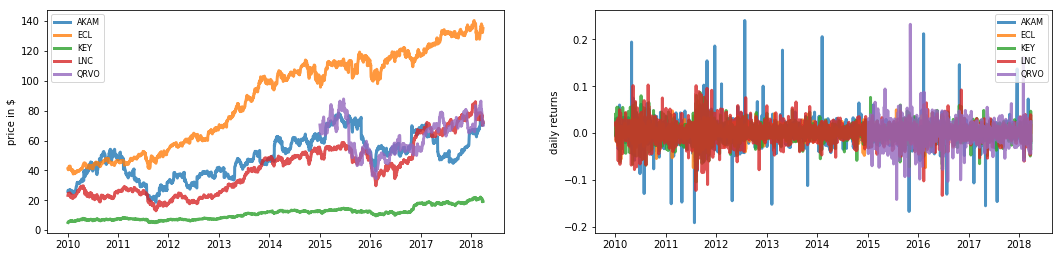

In [10]:
def explore_min_vol(tickers_minvol):
    """Plots ticker price since 2010, 
       
       Plots daily price change movement since 2010
    """
    stocks = tickers_minvol
    data_stocks = quandl.get_table('WIKI/PRICES', ticker=stocks, qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                               date = { 'gte': '2010-1-1', 'lte': '2018-12-31' }, paginate=True)
    stocks_frame = data_stocks.set_index('date')
    stocks_table = stocks_frame.pivot(columns='ticker')
    stocks_table.columns = [col[1] for col in stocks_table.columns]
    table_returns = stocks_table.pct_change()
    
    plt.figure(figsize=(18,9))
    plt.subplot(221)
    for c in stocks_table.columns.values:
        plt.plot(stocks_table.index,stocks_table[c],lw=3,alpha=0.8,label=c)
    plt.legend(loc='upper left', fontsize=8)
    plt.ylabel('price in $')
    
    plt.subplot(222)
    for c in table_returns.columns.values:
        plt.plot(table_returns.index, table_returns[c], lw=3, alpha=0.8,label=c)
    plt.legend(loc='upper right', fontsize=8)
    plt.ylabel('daily returns')
    plt.show()
explore_min_vol(tickers_found_minvol)

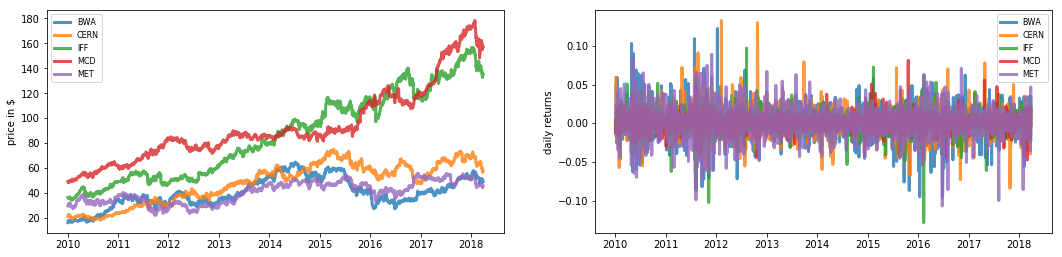

In [11]:
def explore_max_sharpe(tickers_sh):
    stocks = tickers_sh
    data_stocks = quandl.get_table('WIKI/PRICES', ticker=stocks, qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                               date = { 'gte': '2010-1-1', 'lte': '2018-12-31' }, paginate=True)
    stocks_frame = data_stocks.set_index('date')
    stocks_table = stocks_frame.pivot(columns='ticker')
    stocks_table.columns = [col[1] for col in stocks_table.columns]
    table_returns = stocks_table.pct_change()
    
    plt.figure(figsize=(18,9))
    plt.subplot(221)
    for c in stocks_table.columns.values:
        plt.plot(stocks_table.index,stocks_table[c],lw=3,alpha=0.8,label=c)
    plt.legend(loc='upper left', fontsize=8)
    plt.ylabel('price in $')
    
    plt.subplot(222)
    for c in table_returns.columns.values:
        plt.plot(table_returns.index, table_returns[c], lw=3, alpha=0.8,label=c)
    plt.legend(loc='upper right', fontsize=8)
    plt.ylabel('daily returns')
    plt.show()
explore_max_sharpe(tickers_found_shrp)

In [29]:
short_window = 40
long_window = 100
#tickers retrieved from minvol function



stocks_tbl = quandl.get_table('WIKI/PRICES', ticker=tickers_found_minvol, qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                               date = { 'gte': '2017-01-01', 'lte': '2019-01-01' }, paginate=True)

stock_dic = {}




signals = stocks_tbl.set_index('date')
signals = signals.pivot(columns='ticker')
signals.columns = [col[1] for col in signals.columns]
signals_sw = signals.rolling(window=short_window,min_periods=1,center=False).mean()
sep = ''

ticks = []
for i in signals_sw:
    stock_dic[i+"_SW"] = signals_sw[i]
#print(stock_dic['ECL_SW'])


signals_lw = signals.rolling(window=long_window,min_periods=1,center=False).mean()

for i in signals_lw:
    stock_dic[i+'_LW'] = signals_lw[i]

print(stock_dic.keys())

stock_1_both['signal'] = 0.0
stock_1_both['signal'][short_window:] = np.where(stock_1_both['short_'+sep.join([x for x in signals_sw.columns[0]])][short_window:] > 
                                                 stock_1_both['long_'+sep.join([x for x in signals_lw.columns[0]])][short_window:],1.0,0.0)
stock_1_both['positions'] = stock_1_both['signal'].diff()

stock_2_both['signal'] = 0.0
stock_2_both['signal'][short_window:] = np.where(stock_2_both['short_'+sep.join([x for x in signals_sw.columns[1]])][short_window:] > 
                                                 stock_2_both['long_'+sep.join([x for x in signals_lw.columns[1]])][short_window:],1.0,0.0)
stock_2_both['positions'] = stock_2_both['signal'].diff()

stock_3_both['signal'] = 0.0
stock_3_both['signal'][short_window:] = np.where(stock_3_both['short_'+sep.join([x for x in signals_sw.columns[2]])][short_window:] > 
                                                 stock_3_both['long_'+sep.join([x for x in signals_lw.columns[2]])][short_window:],1.0,0.0)
stock_3_both['positions'] = stock_3_both['signal'].diff()


stock_4_both['signal'] = 0.0
stock_4_both['signal'][short_window:] = np.where(stock_4_both['short_'+sep.join([x for x in signals_sw.columns[3]])][short_window:] > 
                                                 stock_4_both['long_'+sep.join([x for x in signals_lw.columns[3]])][short_window:],1.0,0.0)
stock_4_both['positions'] = stock_4_both['signal'].diff()


stock_5_both['signal'] = 0.0
stock_5_both['signal'][short_window:] = np.where(stock_5_both['short_'+sep.join([x for x in signals_sw.columns[4]])][short_window:] > 
                                                 stock_5_both['long_'+sep.join([x for x in signals_lw.columns[4]])][short_window:],1.0,0.0)
stock_5_both['positions'] = stock_5_both['signal'].diff()

#print(stock_1_both.tail())
#print(stock_2_both.tail())
#print(stock_3_both.tail())
#print(stock_4_both.tail())
#print(stock_5_both.tail())

dict_keys(['AKAM_SW', 'ECL_SW', 'KEY_SW', 'LNC_SW', 'QRVO_SW', 'AKAM_LW', 'ECL_LW', 'KEY_LW', 'LNC_LW', 'QRVO_LW'])


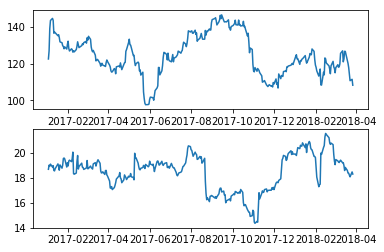

In [53]:

x = {}
for num, i in enumerate(signals.columns):
    x[num] = quandl.get('WIKI/'+i, start_date="2017-01-01", end_date="2019-01-01")
 
plt.subplot(2,1,1)
plt.plot(x[0]['Close'])



plt.subplot(2,1,2)
plt.plot(x[1]['Close'])
plt.show()